In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [6]:
path = '/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/qcd/singles'

In [7]:
qcd = {}
files = os.listdir(f'{path}')
for i in files:
    if 'qcd' in i:
        qcd[i.rstrip('.parquet')] = ak.firsts(ak.from_parquet(f'{path}/{i}'))

In [8]:
qcd

{'qcd_1000to1400': <Array [{goodjets: {...}, ...}, ..., {...}] type='225335 * {goodjets: ?{are...'>,
 'qcd_1400to1800': <Array [{goodjets: {...}, ...}, ..., {...}] type='97665 * {goodjets: ?{area...'>,
 'qcd_1800to2400': <Array [{goodjets: {...}, ...}, ..., {...}] type='39758 * {goodjets: ?{area...'>,
 'qcd_2400to3200': <Array [{goodjets: {...}, ...}, ..., {...}] type='15666 * {goodjets: ?{area...'>,
 'qcd_300to470': <Array [{goodjets: {...}, ...}, ..., {...}] type='621230 * {goodjets: ?{are...'>,
 'qcd_3200toInf': <Array [{goodjets: {...}, ...}, ..., {...}] type='3618 * {goodjets: ?{area:...'>,
 'qcd_470to600': <Array [{goodjets: {...}, ...}, ..., {...}] type='4174788 * {goodjets: ?{ar...'>,
 'qcd_600to800': <Array [{goodjets: {...}, ...}, ..., {...}] type='1292359 * {goodjets: ?{ar...'>,
 'qcd_800to1000': <Array [{goodjets: {...}, ...}, ..., {...}] type='345179 * {goodjets: ?{are...'>}

In [9]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
        sample = sample[mask]
    return sample

In [10]:
hgg = hgg[hgg.msoftdrop < 170]
hgg = hgg[hgg.msoftdrop > 80]
hgg = hgg[hgg.pt < 600]
hgg = hgg[hgg.pt > 450]

NameError: name 'hgg' is not defined

In [97]:
qcd_control = qcd_control[qcd_control.msoftdrop < 200]
qcd_control = qcd_control[qcd_control.msoftdrop > 40]
qcd_control = qcd_control[qcd_control.pt < 600]
qcd_control = qcd_control[qcd_control.pt > 450]

In [140]:
hgg = nan_remover(hgg)

In [98]:
qcd = nan_remover(qcd)

In [85]:
qcd_control = nan_remover(qcd_control)

In [13]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [15]:
qcd_frac = {}
for i in qcd:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in qcd:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in qcd:
    temp = qcd[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
qcd_stitched = ak.concatenate([combed[x] for x in combed])

In [37]:
qcd_stitched = qcd_stitched[qcd_stitched.msoftdrop < 200]
qcd_stitched = qcd_stitched[qcd_stitched.msoftdrop > 40]
qcd_stitched = qcd_stitched[qcd_stitched.pt < 600]
qcd_stitched = qcd_stitched[qcd_stitched.pt > 450]

In [38]:
for i in qcd:
    qcd[i] = qcd[i][qcd[i].msoftdrop < 200]
    qcd[i] = qcd[i][qcd[i].msoftdrop > 40]
    qcd[i] = qcd[i][qcd[i].pt < 600]
    qcd[i] = qcd[i][qcd[i].pt > 450]

In [39]:
model = f'../../../ml/ml_processor_work/models_and_scalers/full_cut/qcd/hgg_traced_model.pt'

In [40]:
with open(f'../../../ml/ml_processor_work/models_and_scalers/full_cut/qcd/hgg_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [41]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                # 'n2b1': fatjets.n2b1,
                # 'n3b1': fatjets.n3b1,
                # 'nConstituents': fatjets.nConstituents,
                # 'color_ring': fatjets.color_ring,
                'd2b1': fatjets.d2b1,
                # 'u1': fatjets.u1,
                # 'u2': fatjets.u2,
                # 'u3': fatjets.u3,
                # 'd3': fatjets.d3,
                # 'm2': fatjets.m2,
                # 'm3': fatjets.m3,
                # 'n4': fatjets.n4,
                # 'mratio': fatjets.mratio,
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [42]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [141]:
hgg_scores = tagger(hgg, scaler)[:,0]

In [48]:
qcd_stitch_scores = tagger(qcd_stitched, scaler)[:,0]

In [99]:
qcd_control_scores = tagger(qcd_control, scaler)[:,0]

In [45]:
qcd_scores = {}
for i in qcd:
    qcd_scores[i] = tagger(qcd[i], scaler)[:,0]

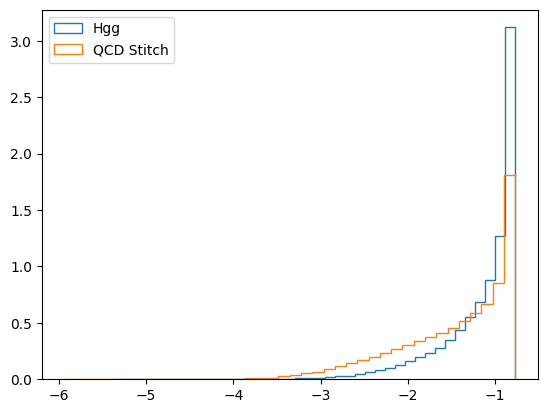

In [142]:
plt.hist(hgg_scores, bins=40, histtype='step', density=True, label='Hgg')
plt.hist(qcd_control_scores, bins=40, histtype='step', density=True, label='QCD Stitch')
plt.legend()
plt.show()

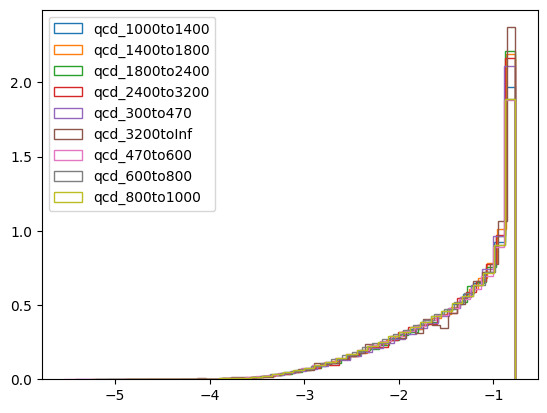

In [52]:
for i in qcd_scores:
    plt.hist(qcd_scores[i], bins=40, histtype='step', density=True, label=f'{i}')
plt.legend()
plt.show()

In [71]:
def simple_roc(qcd_scores, hgg_scores):
    bkg_zeros = ak.zeros_like(qcd_scores)
    sig_ones = ak.ones_like(hgg_scores)
    combined = ak.concatenate([qcd_scores,hgg_scores])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])

    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)

    hrange=(np.floor(ak.min(qcd_scores)), np.ceil(ak.max(qcd_scores)))

    hgg_hist = np.histogram(hgg_scores, bins=100,
                    range=hrange
                    )
    qcd_hist = np.histogram(qcd_scores, bins=100, 
                     range=hrange
                    )

    sig_sums = []
    for i in range(len(hgg_hist[0])+1):
        sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))
    
    bkg_sums = []
    for i in range(len(qcd_hist[0])+1):
        bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

    sig_ratios = []
    for i in sig_sums:
        sig_ratios.append(i/sig_sums[-1])
    bkg_ratios = []
    for i in bkg_sums:
        bkg_ratios.append(i/bkg_sums[-1])

    wp_ratios = {}
    for i in range(len(hgg_hist[1])):
        wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]



    return fpr, tpr, roc_auc, wp_ratios

In [143]:
fpr, tpr, roc_auc, wp_ratios = simple_roc(qcd_control_scores, hgg_scores)

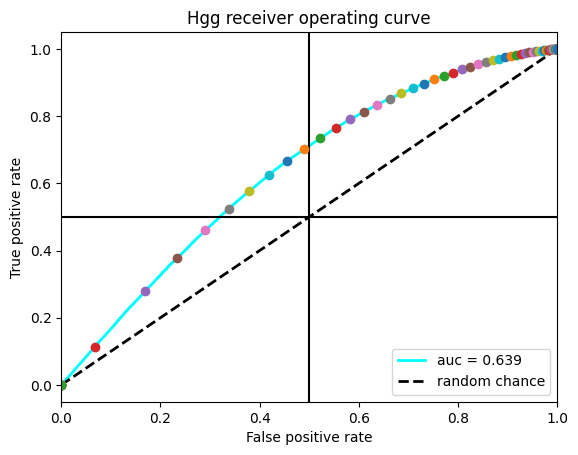

In [144]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {str(i)}')
#plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [145]:
cut = float(min(wp_ratios.items(), key=lambda x: abs(.5-x[1][0]))[0])

In [146]:
mask = ~((qcd_stitch_scores > cut))
qcd_cut_msd = qcd_stitched.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [147]:
mask = ((qcd_stitch_scores > cut))
qcd_cut_msd = qcd_stitched.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [148]:
with open('../sample_stitching/event_total.json', 'r') as f:
    totals = json.load(f)
with open('../../../ml/ml_processor_work/jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [149]:
scale = ((44.99*(max(xsecs['qcd'].values())*1000))/sum(totals['qcd'][j] for j in totals['qcd']))

In [150]:
qcd_pass_hist.view(flow=True)[:] *= scale
qcd_fail_hist.view(flow=True)[:] *= scale

In [151]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

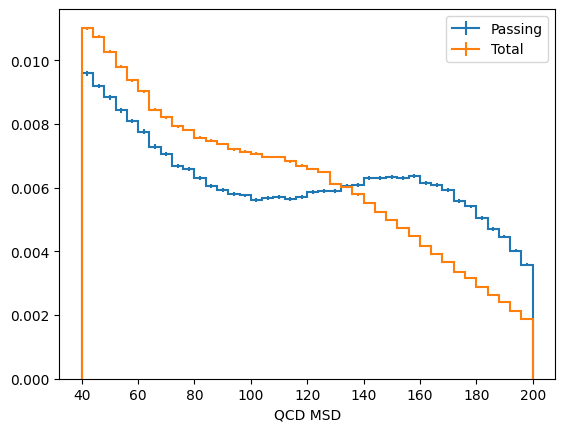

In [152]:
qcd_pass_hist.plot1d(density=True, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_qcd_hist.plot1d(density=True, label='Total')
plt.legend()
plt.show()